In [1]:
#导入数据分析常用的工具包

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#导入keras和opencv工具包

import keras
from keras.preprocessing.image import load_img,img_to_array,array_to_img,ImageDataGenerator
import cv2

Using TensorFlow backend.


## 1.读入数据

In [3]:
#图片的根目录
root = 'D:\image_dataset\dataset-resized'
#列出根目录下所有的文件夹
dirt_list = os.listdir(root)
X = []#存储读取的图片
Y = []#存储读取的标签
class_num = 0 #记录类别编号

for dirt in dirt_list:
    img_list = os.listdir(os.path.join(root,dirt))#列出当前文件夹下所有的图片，同属于一个类
    for img_name in img_list:
        
        img = cv2.imread(os.path.join(root,dirt,img_name))#使用opencv读取图片
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)#将读取到图片转化为224*224的大小
        img = np.array(img)#将图片数据转化为ndarray格式
        img = img.astype(np.float32)#将数据类型转化为float格式
        X.append(img)#将读取到图片添加到X列表当中来
        Y.append(class_num)#将标签添加到Y列表当中
        
    class_num += 1

In [4]:
#查看每个类别的数量
for i in range(6):
    print(Y.count(i))

403
501
410
594
482
137


In [5]:
from keras.utils import to_categorical

X = np.array(X)#将list格式转化为ndarray格式
X = np.multiply(X,1.0/255)#对X进行归一化处理
Y = to_categorical(Y)#将标签Y转化为one_hot编码格式

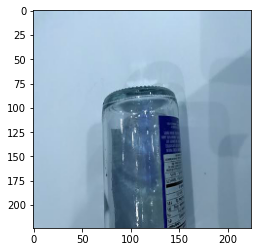

In [6]:
#展示其中一张图片
plt.imshow(X[685])

## 2.切分数据

In [7]:
#将数据切分为训练集和测试集
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 0)

In [8]:
print('训练集的大小:',X_train.shape[0])
print('测试集的大小:',X_test.shape[0])

训练集的大小: 2021
测试集的大小: 506


In [9]:
#将训练集切分为训练集和验证集
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size = 0.25,random_state = 1)

print('训练集的大小:',X_train.shape[0])
print('验证集的大小:',X_val.shape[0])

训练集的大小: 1515
验证集的大小: 506


## 3.数据增强

In [10]:
train_datagen = ImageDataGenerator(rotation_range = 360,
                            width_shift_range = 0.3,
                            height_shift_range = 0.3,
                            horizontal_flip = True,
                            vertical_flip = True,
                            zoom_range = 0.3,
                            shear_range = 30)
val_datagen = ImageDataGenerator()

## 4.构建模型

In [11]:
#导入3种预训练的模型
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras.layers import GlobalAveragePooling2D,Dense,ReLU,Dropout,BatchNormalization

from keras.models import Model,load_model

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from keras.optimizers import SGD,Adam

In [12]:
from keras import layers

#定义模型构建函数
def build_model():
    base_model = Xception(include_top = False,input_shape = (224,224,3),weights = 'imagenet',pooling = 'avg')
    
    x = layers.Flatten()(base_model.output)
    x = Dense(1024,activation = None)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(6,activation = 'softmax')(x)
    
    model = Model(base_model.input,outputs)
    
    return(model)

In [13]:
#构建训练数据的迭代器
train_generator = train_datagen.flow(X_train,Y_train,batch_size = 64)
val_generator = val_datagen.flow(X_val,Y_val,batch_size = 64)

In [14]:
#定义模型的训练策略和保存策略
checkpoint = ModelCheckpoint('rubbish_classification_xception.h5',monitor = 'val_loss',verbose = 1,
                                  save_best_only = True)
earlystop = EarlyStopping(monitor = 'val_loss',patience = 6)

reduceler = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,min_lr = 1e-6)

In [15]:
#构建模型

model = build_model()
model.compile(loss = 'categorical_crossentropy',optimizer = Adam(1e-3),metrics = ['acc'])

In [17]:
#训练模型

history = model.fit_generator(train_generator,steps_per_epoch = 3*51,epochs = 25,validation_data = val_generator,
                             callbacks = [reduceler,earlystop,checkpoint])

Epoch 1/25
 24/153 [===>..........................] - ETA: 1:05:00 - loss: 0.7020 - acc: 0.7611WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3825 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss did not improve from 2.81236
 24/153 [===>..........................] - 765s 32s/step - loss: 0.7020 - acc: 0.7611 - val_loss: 10.9207 - val_acc: 0.3360 - lr: 0.0010
